In [1]:
# the intention of this script is to retrieve each university out of "College Rankings __ Attractiveness of the Students" + num + ".html" and store it in a list
# the list will be used to create an dataframe with the university and attractiveness
# the script will then find the state of each university and store it with the university and attractiveness
# the script will then calculate each state's average attractiveness and store it in a dataframe
# this dataframe will be used to create a heatmap of the US with the average attractiveness of each state

In [7]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
universities = []
attractiveness = []

# retrieve the universities and attractiveness score from each html file

for i in range(1, 7):
    with open("College Rankings __ Attractiveness of the Students" + str(i) + ".html") as f:
        soup = BeautifulSoup(f, 'html.parser')
        universitiesBS = soup.find_all('a', class_='ratings_list')
        for university in universitiesBS:
            universities.append(university.string)
        attractivenessBS = soup.find_all('div', align='right')
        for attr in attractivenessBS:
            attractiveness.append(attr.string)


# clean the attractiveness list
# remove all the None values
attractiveness = [x for x in attractiveness if x is not None]

# remove all the elements which start with S, as they are not floats
attractiveness = [x for x in attractiveness if not x.startswith('S')]

#print(universities)
#print(attractiveness)

print(len(universities))
print(len(attractiveness))


505
505


In [42]:
# create a dataframe with the universities and their attractiveness
df = pd.DataFrame({"University": universities, "Attractiveness": attractiveness})

# replace "Malone College" with "Malone University" as it is now known
df.loc[df["University"] == "Malone College", "University"] = "Malone University"

# print the head and tail of the dataframe by combining them and printing them
pd.concat([df.head(), df.tail()])

,University,Attractiveness
0,Pepperdine University,89.7
1,Villanova University,87.8
2,Vanderbilt University,87.5
3,Texas Christian University,87.2
4,Southern Methodist University,87.0
500,Worcester Polytechnic Institute,28.2
501,"University of Missouri, Rolla",27.5
502,Polytechnic University,26.7
503,Rose-Hulman Institute of Technology,26.4
504,Clarkson University,24.1


In [67]:

# list of all the states in the US for simple regex matching (taken from https://gist.github.com/norcal82/e4c7e8113f377db184bb)
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]


In [ ]:

# create a list of the states of the universities
state = []

# create a list of the universities that couldn't be found
not_found = []

for i in range(len(df["University"])): #
    # check to see if one of the words in the university name is a state
    for word in df["University"][i].split():
        if word in state_names:
            state.append(word)
            break
        elif word == "SUNY" or word == "CUNY":
            state.append("New York")
            break
        elif word == "Rhode":
            state.append("Rhode Island")
            break
        else:
            state.append(None)
    
    if state[-1] == None:
        # remove the None value from the end of the list and continue to use wikipedia
        state.pop(-1)
    else:
        # if the state was found in the university name, continue to the next university
        continue

    url = "https://en.wikipedia.org/wiki/" + df["University"][i]
    # if the university has a space in its name, replace it with an underscore
    url = re.sub(r" ", "_", url)
    #print(url)
    # if the university has a parenthesis or a comma in its name, remove it along with the rest of the name
    url = re.sub(r"_\(.*", "", url)
    url = re.sub(r",.*", "", url)
    # if the university has the words "Main Campus" in its name, remove it
    url = re.sub(r"Main_Campus", "", url)

    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    print(str(i/len(df["University"])*100) + "%")
    try:
        state.append(soup.find_all("div", class_="state")[0].string)
    except:
        state.append(None)
    
    if state[-1] == None or state[-1] == "N/A":
        try:
            state[-1] = soup.find_all("div", class_="locality")[0].string
            # if there's a comma+space in the locality, remove it along with everything before it
            state[-1] = re.sub(r".*, ", "", state[-1])
        except:
            state[-1] = "N/A"
            print("N/A: " + url)
            not_found.append(df["University"][i])
    
    if i % 50 == 0:
        print(str(i/len(df["University"])*100) + "%")


In [69]:
print(not_found)
# remove all None values from the state list
#state = [x for x in state if x is not None]
print(len(state))
print(len(df["University"]))
print(len(not_found))


['Gannon University', 'Wheaton College', "Saint Mary's College", 'Gordon College', 'Saint Louis University, Main Campus', 'City College', 'Trinity University', 'Luther College', 'Loyola University, Chicago', 'Vassar College', 'National University', 'Saint Johns University', 'Kaplan College', 'University of The Arts', 'City University', "St John's College", 'Johnson & Wales University', 'Baker College of Auburn Hills', 'Polytechnic University']
505
505
19


In [ ]:

for state_name in state:
    if state_name not in state_names and state_name != "N/A":
        print(state_name)
        if "D.C." in state_name:
            state[state.index(state_name)] = "District of Columbia"

In [83]:

# add the states to the dataframe
df["State"] = state

# save the dataframe to a csv file
df.to_csv("universitiesAttractiveness.csv")

# print them
df

,University,Attractiveness,State
0,Pepperdine University,89.7,California
1,Villanova University,87.8,Pennsylvania
2,Vanderbilt University,87.5,Tennessee
3,Texas Christian University,87.2,Texas
4,Southern Methodist University,87.0,Texas
...,...,...,...
500,Worcester Polytechnic Institute,28.2,Massachusetts
501,"University of Missouri, Rolla",27.5,Missouri
502,Polytechnic University,26.7,N/A
503,Rose-Hulman Institute of Technology,26.4,Indiana


In [71]:

# calculate the average attractiveness of each state
average_attractiveness = []
for i in df["State"].unique():
    average_attractiveness.append(df[df["State"] == i]["Attractiveness"].astype(float).mean())


In [73]:
print(df["State"].unique())
print(state_names)
print(len(df["State"].unique()))
for state_name in df["State"].unique():
    if state_name not in state_names:
        print(state_name)

['California' 'Pennsylvania' 'Tennessee' 'Texas' 'Arizona' 'Ohio'
 'Mississippi' 'South Carolina' 'Florida' 'Colorado' 'North Carolina'
 'Georgia' 'Washington' 'Alabama' 'New Jersey' 'Minnesota' 'Delaware'
 'Michigan' 'Virginia' 'Oklahoma' 'Indiana' 'Utah' 'Hawaii' 'Louisiana'
 'N/A' 'New York' 'Kentucky' 'Maryland' 'Idaho' 'Oregon' 'Massachusetts'
 'Kansas' 'New Hampshire' 'Connecticut' 'Arkansas' 'Vermont' 'Missouri'
 'Nebraska' 'Wisconsin' 'Montana' 'Iowa' 'Illinois' 'South Dakota'
 'West Virginia' 'North Dakota' 'District of Columbia' 'Nevada' 'Maine'
 'Rhode Island' 'New Mexico' 'Wyoming' 'Alaska']
['Alaska', 'Alabama', 'Arkansas', 'American Samoa', 'Arizona', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Delaware', 'Florida', 'Georgia', 'Guam', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts', 'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Missouri', 'Mississippi', 'Montana', 'North Carolina', 'North Dakota',

In [82]:

# create a dataframe with the states and their average attractiveness
df2 = pd.DataFrame({"State": df["State"].unique(), "Average Attractiveness": average_attractiveness})

# save the dataframe to a csv file
df2.to_csv("average_attractiveness.csv")

# Remove the N/A state
df2 = df2[df2["State"] != "N/A"]


In [4]:
# United States of America Python Dictionary to translate States,
# Districts & Territories to Two-Letter codes and vice versa.
#
# Canonical URL: https://gist.github.com/rogerallen/1583593
#
# Dedicated to the public domain.  To the extent possible under law,
# Roger Allen has waived all copyright and related or neighboring
# rights to this code.  Data originally from Wikipedia at the url:
# https://en.wikipedia.org/wiki/ISO_3166-2:US
#
# Automatically Generated 2021-09-11 18:04:36 via Jupyter Notebook from
# https://gist.github.com/rogerallen/d75440e8e5ea4762374dfd5c1ddf84e0 

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
    
# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

In [5]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

# load the df2 dataframe from the csv file
df2 = pd.read_csv("average_attractiveness.csv")

# load the df dataframe from the csv file
#df = pd.read_csv("universitiesAttractiveness.csv")

In [6]:
# drop the first column of the df dataframe
df2 = df2.drop(columns="Unnamed: 0")

# convert each state in the df2 dataframe to its abbreviation
df2["State"] = df2["State"].map(us_state_to_abbrev)

# sort the df2 dataframe by the attractiveness
df2 = df2.sort_values("Average Attractiveness", ascending=False, ignore_index=True)

In [48]:
# go through each state to ensure the state is a state
for i in range(len(df2["State"])):
    if df2["State"][i] not in us_state_to_abbrev.keys():
        print(df2["State"][i])
        # if the state is not a state, remove it from the dataframe
        df2 = df2.drop(i)

df2.reset_index(drop=True, inplace=True)

df2

nan


,State,Average Attractiveness
0,Hawaii,77.600000
1,Mississippi,76.900000
2,Utah,73.140000
3,South Carolina,72.150000
4,Delaware,72.050000
5,North Carolina,71.990909
6,Arkansas,70.025000
7,Louisiana,69.357143
8,Florida,69.190000
9,Nebraska,68.450000


In [9]:


# use the plotly library to create a heatmap of the US with the average attractiveness of each state
import plotly.express as px
import nbformat

fig = px.choropleth(locations=df2["State"], locationmode="USA-states", color=df2["Average Attractiveness"], scope="usa", title="Average Attractiveness of Students by State")
# change the size of the heatmap
fig.update_layout(height=800)
fig.update_layout(title_x=0.5)
fig.update_geos(fitbounds="locations", visible=False)
fig.write_html("attractiveness_heatmap.html")
fig.show()



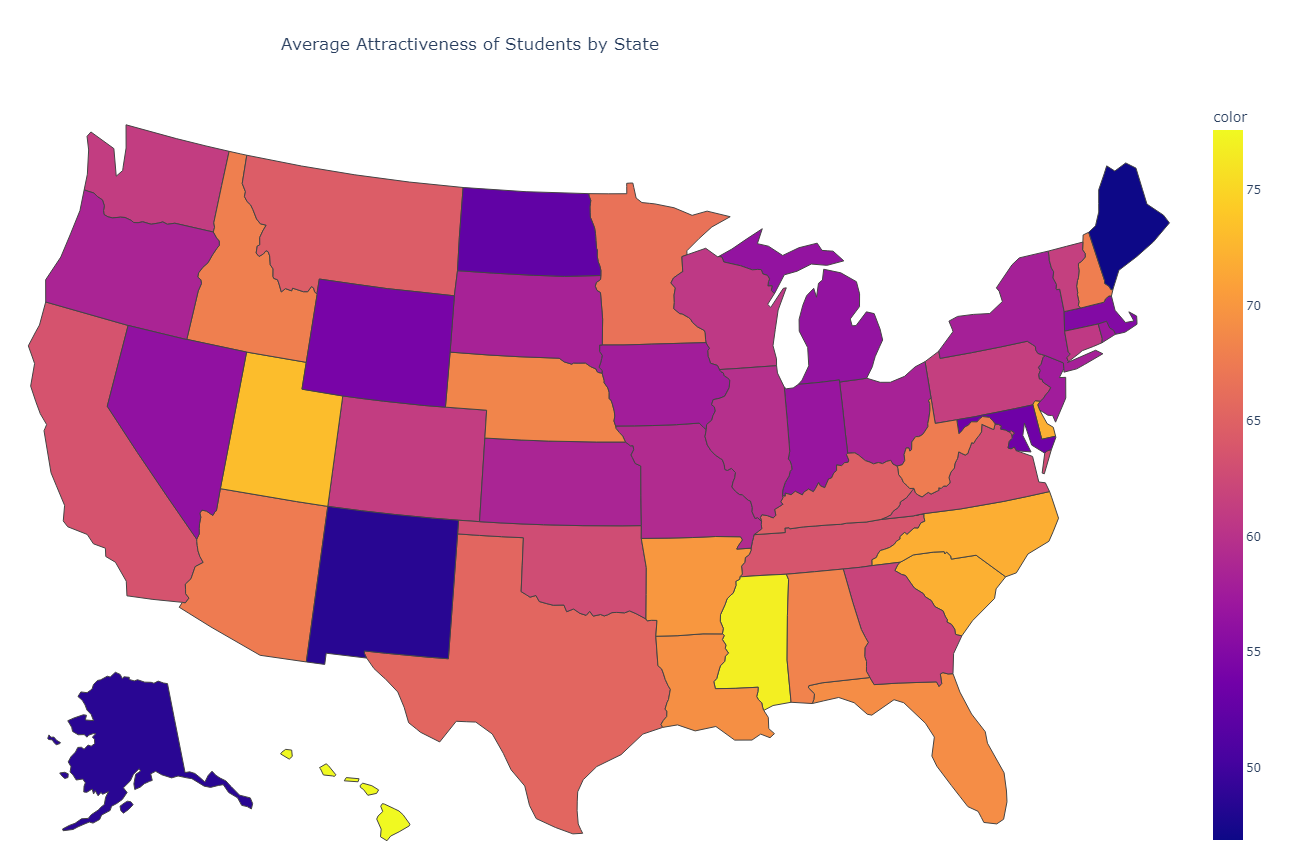

In [11]:
# show the heatmap as a png image from newplot.png on the notebook
from IPython.display import Image
Image(filename="newplot.png")